# Key Terms Extractor
This is a short NLP project I did through JetBrains academy. One common problem in NLP is identifing the subject or subjects of a text. In this mini-project I'm going to attempt to extract the top-5 key terms that are related to the subject of several texts in a few different ways. To start off I'll just get the counts of each of the words, and to end we'll attempt to calculate the TF-IDF score for each of the words in each of our texts.


## First, a little exploration
Before I start digging into Python's nltk library the tools it offers. I want to do a little text processing and playing around on my own, just to feel things out.

### The test files
The texts I'm going to be working with are buried in the news.xml file. So, to start off, I'm going to extract each of the texts from the file. I'll do this using Python's nifty lxml library. From here I'll put the texts into a list of tuples called ```articles```. Each tuple will contain the name of the piece of text and the raw text. 

In [10]:
from lxml import etree

filename = "news.xml"
f = open(filename, "rb")

xml_tree = etree.fromstring(f.read())
articles = [(article[0].text, article[1].text) for article in xml_tree[0]]
articles[0]

('Brain Disconnects During Sleep',
 "Scientists may have gained an important insight into the age-old mystery of why consciousness fades as we nod off to sleep.\n          Lines of communication between various parts of cerebral cortex - which buzz with activity during wakefulness - break down during slumber, researchers report today in Science.\n          Early neuroscientists assumed that consciousness wanes during sleep because the cortex simply shuts off.\n          But electroencephalography (EEG) and other modern methods have since ruled out that explanation, showing that the electrical chatter and metabolism of neurons in the cortex continues unabated during sleep.\n          That left neuroscientists with a puzzle: If the brain is still active, why does consciousness wane?\n          Giulio Tononi of the University of Wisconsin, Madison, suspected that a communication breakdown might be the reason.\n          Tononi has spent years developing a theory that equates consciousness

Alright now lets just count the words in the raw text for each of the news articles. We'll perform a little preprocessing to make things a little cleaner. Basically just coverting all the text to lowercase and stripping away all the whitespace.

In [11]:
from collections import defaultdict
import pandas as pd

def get_word_counts(text):
    article_counts = defaultdict(int)
    for word in text.lower().split():
        article_counts[word] += 1
    return article_counts

counts = [get_word_counts(article[1]) for article in articles]

### Some simple visualizations
The dictionaries from before don't tell us a whole lot. At least not at a quick glance. To make things a little prettier, I decided to make some bar charts using pandas to visualize the counts of the words in each article. 

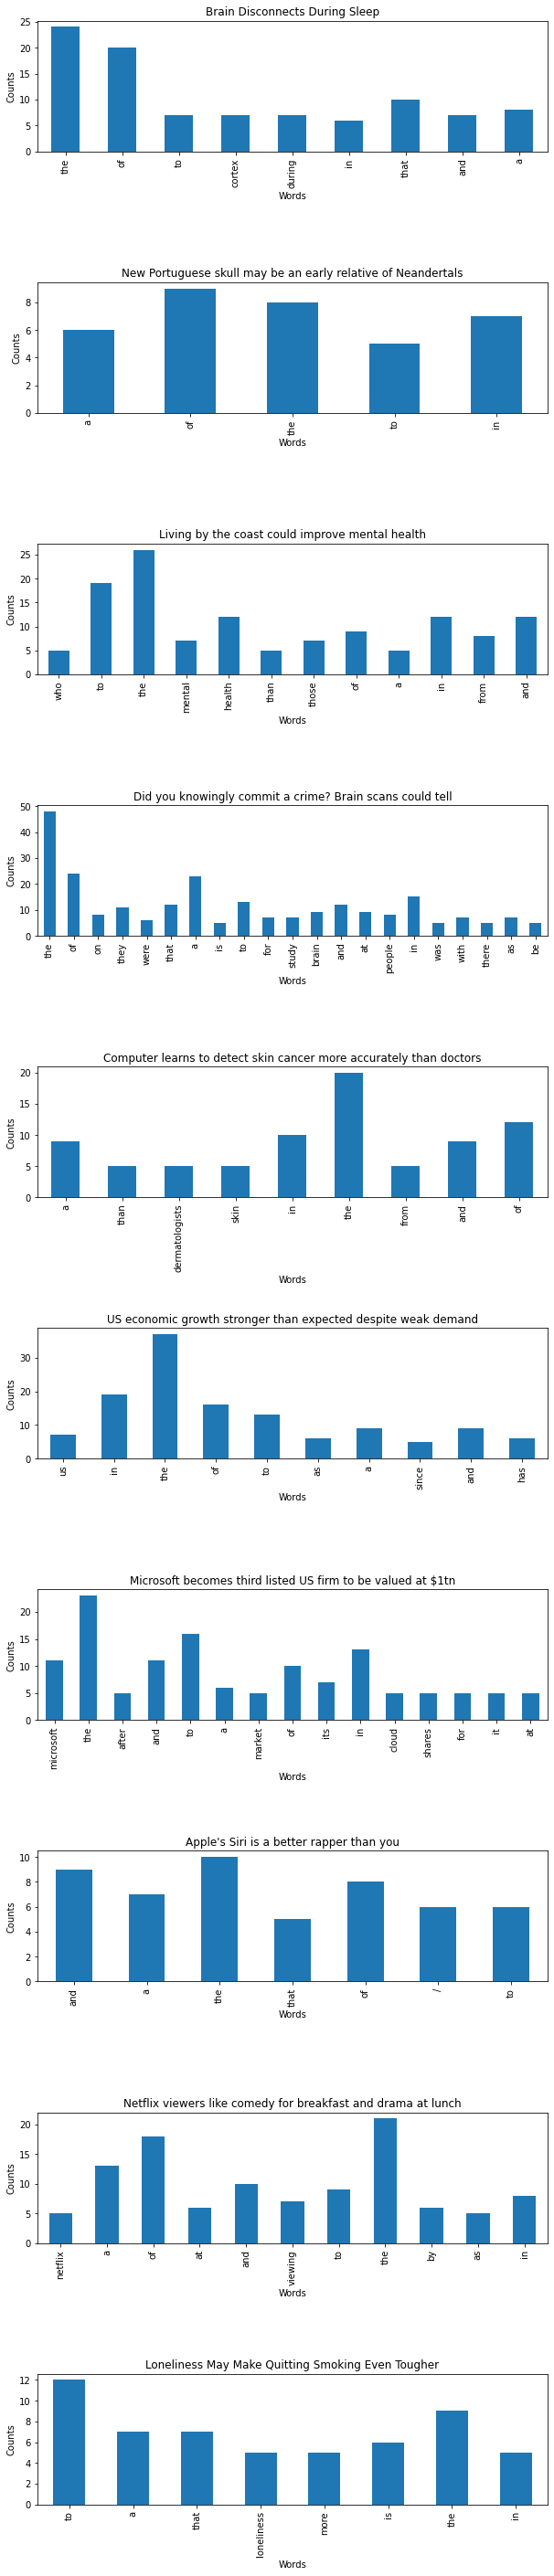

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, gridspec_kw={'hspace': 1}, figsize=(10, 50))

for i in range(0, 10):
    series = pd.Series(data=counts[i])
    series[series >= 5].plot(ax=axs[i], kind='bar', ylabel='Counts', xlabel='Words').set_title(articles[i][0])


### Removing Stopwords and Punctuation
Now, as expected, the most common words in each of these these articles are **stopwords**. For my next bit of processing, I'm is going to remove the stopwords from each of the texts. Fortunatly, Python's ```nltk``` library has a whole list of stopwords for me to pull from.

In addition to this I will also be removing the punctuation from the text. 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


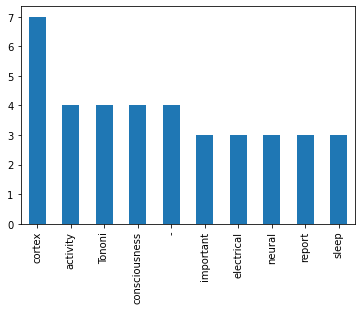

In [13]:
from string import punctuation

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_punctuation(text):
    for char in punctuation:
        text = text.replace(char, "")
    return text

def remove_stopwords(word_list):
    return [word for word in word_list if word not in stopwords.words('english')]

series = pd.Series(data=remove_stopwords(articles[0][1].split())).value_counts()

series[series >= 3].plot.bar()

Now this graph is only for the first piece of text, but from what I can tell it looks much better than before. The title of the article is, "Brain Disconnects During Sleep," and the most frequent words appear to be related to this. We've got cortex, activity, sleep, neural which are related to the subject matter.

## The Power of Python's NLTK Library
Now that I've messed around a little, let's get to the good stuff. Python's NLTK library provides a ton of useful tools for natural language processing. In this project, we're going to explore some of the tools NLTK offers for tokenization, lemmatization, and pos-tagging. I'm also going to use a TF-IDF vectorizer from scikit-learn to calculate the the TF-IDF scores for our tokens.

### Tokenization
To start off, I'm going to take the original texts from the news articles and pass them through nltk's ```word_tokenize``` method.

In [14]:
import nltk
nltk.download('punkt')

from nltk import word_tokenize

text_tokens = [word_tokenize(article[1]) for article in articles]
text_tokens[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Scientists',
 'may',
 'have',
 'gained',
 'an',
 'important',
 'insight',
 'into',
 'the',
 'age-old',
 'mystery',
 'of',
 'why',
 'consciousness',
 'fades',
 'as',
 'we',
 'nod',
 'off',
 'to',
 'sleep',
 '.',
 'Lines',
 'of',
 'communication',
 'between',
 'various',
 'parts',
 'of',
 'cerebral',
 'cortex',
 '-',
 'which',
 'buzz',
 'with',
 'activity',
 'during',
 'wakefulness',
 '-',
 'break',
 'down',
 'during',
 'slumber',
 ',',
 'researchers',
 'report',
 'today',
 'in',
 'Science',
 '.',
 'Early',
 'neuroscientists',
 'assumed',
 'that',
 'consciousness',
 'wanes',
 'during',
 'sleep',
 'because',
 'the',
 'cortex',
 'simply',
 'shuts',
 'off',
 '.',
 'But',
 'electroencephalography',
 '(',
 'EEG',
 ')',
 'and',
 'other',
 'modern',
 'methods',
 'have',
 'since',
 'ruled',
 'out',
 'that',
 'explanation',
 ',',
 'showing',
 'that',
 'the',
 'electrical',
 'chatter',
 'and',
 'metabolism',
 'of',
 'neurons',
 'in',
 'the',
 'cortex',
 'continues',
 'unabated',
 'during',
 'sle

Ahh. Now that's kinda nice. All of the words, punctuation, numbers, and other special characters have been isolated for us and put into a big list. This will make things much easier to process.

### A little cleaning
Now, lets try removing the stopwords and punctuation from this list and then try plotting the most frequent words again.

To do this, I'm going to use Python's filter method and lambda expressions. The first filter filters out the stopwords, and the second filter filters out the punctuation.

In [15]:
new_tokens = []

for tokens in text_tokens:
    filter_stopwords = list(filter(lambda x: x not in stopwords.words('english'), tokens))
    filter_punctuation = list(filter(lambda x: x not in punctuation, filter_stopwords))

    new_tokens.append(filter_punctuation)

new_tokens[0]

['Scientists',
 'may',
 'gained',
 'important',
 'insight',
 'age-old',
 'mystery',
 'consciousness',
 'fades',
 'nod',
 'sleep',
 'Lines',
 'communication',
 'various',
 'parts',
 'cerebral',
 'cortex',
 'buzz',
 'activity',
 'wakefulness',
 'break',
 'slumber',
 'researchers',
 'report',
 'today',
 'Science',
 'Early',
 'neuroscientists',
 'assumed',
 'consciousness',
 'wanes',
 'sleep',
 'cortex',
 'simply',
 'shuts',
 'But',
 'electroencephalography',
 'EEG',
 'modern',
 'methods',
 'since',
 'ruled',
 'explanation',
 'showing',
 'electrical',
 'chatter',
 'metabolism',
 'neurons',
 'cortex',
 'continues',
 'unabated',
 'sleep',
 'That',
 'left',
 'neuroscientists',
 'puzzle',
 'If',
 'brain',
 'still',
 'active',
 'consciousness',
 'wane',
 'Giulio',
 'Tononi',
 'University',
 'Wisconsin',
 'Madison',
 'suspected',
 'communication',
 'breakdown',
 'might',
 'reason',
 'Tononi',
 'spent',
 'years',
 'developing',
 'theory',
 'equates',
 'consciousness',
 'integration',
 'informatio

The results for the first article look... okay. We've got words like **cortex**, **sleep**, and **conciousness** which are related to the article, but words like **says** and **activity** don't really tell us anything about the subject of the article. 

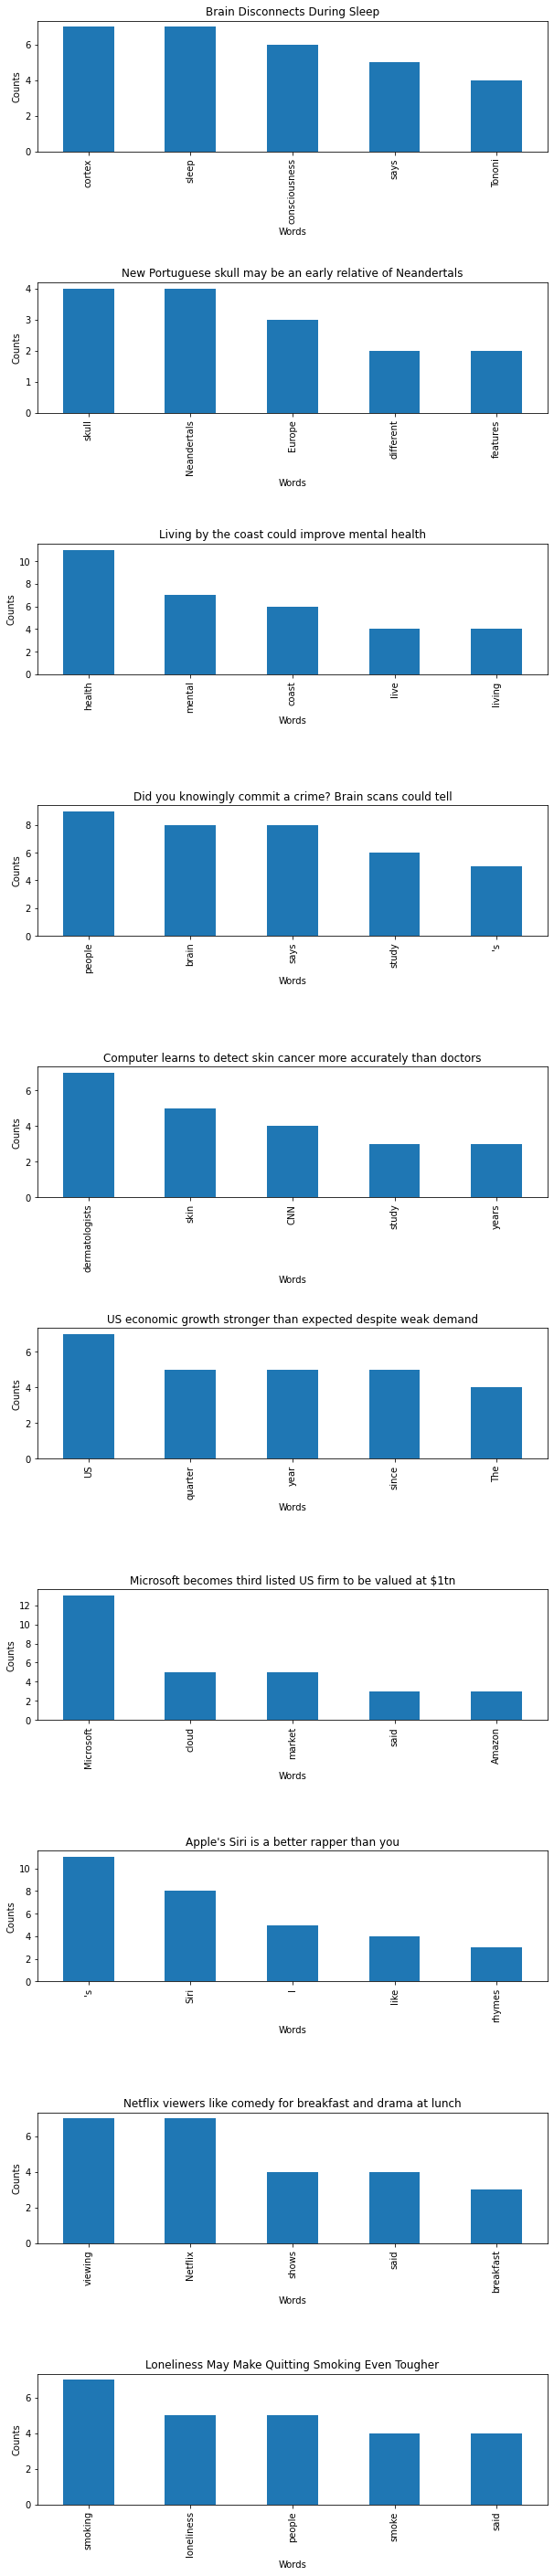

In [16]:
fig, axs = plt.subplots(10, gridspec_kw={'hspace': 1}, figsize=(10, 50))

titles = [a[0] for a in articles]

for i, title in zip(range(0, 10), titles):
    series = pd.Series(data=new_tokens[i]).value_counts()
    series.head().plot(ax=axs[i], kind='bar', ylabel='Counts', xlabel='Words').set_title(title)

### POS-tagging
Next, we want to figure out each tokens *part-of-speech*. Ie whether we're dealing with a verb, a noun, an adjective, etc. Typcially the subject of some piece of text is a noun, so perhaps, if we can identify the the frequently occuring nouns in each of the texts, we could get an even better feel for what the subject of each of the articles is.To do this we'll use nltk's ```pos_tag```, a pretrained model for figuring out the POS of a word.


To start, I'm just going to get the POS-tags for the first article.

In [17]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

pos_tag(new_tokens[0][:10])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


[('Scientists', 'NNS'),
 ('may', 'MD'),
 ('gained', 'VB'),
 ('important', 'JJ'),
 ('insight', 'JJ'),
 ('age-old', 'JJ'),
 ('mystery', 'NN'),
 ('consciousness', 'NN'),
 ('fades', 'NNS'),
 ('nod', 'VBP')]

These are the POS-tags for all the tokens in the first article. There's three main categories we are concerned with, namely nouns, verbs, and adjectives. Some of the other misc tags, such as 'WW' and 'IN' don't really help us.

From here, we'll get the rest of the tags for the tokens from the other articles with their POS-tags and save them in the variable ```tagged_tokens```.

In [30]:
tagged_tokens = [pos_tag(tokens) for tokens in new_tokens]

Now that we've got the tags, I want to see what the top-5 most frequently occuring nouns are in each of the articles. 

We'll start by experimenting with the first article, ```tagged_tokens[0]```.

In [33]:
# Takes a list of tuples, where each tuple contains a word and it's POS-tag
def get_noun_counts(tagged_tokens) -> defaultdict(int):
    nouns = list(filter(lambda t: t[1].startswith("NN"), tagged_tokens))
    counts = defaultdict(int)

    for noun in nouns:
        counts[noun[0]] += 1
    return counts

noun_counts = get_noun_counts(tagged_tokens[0])

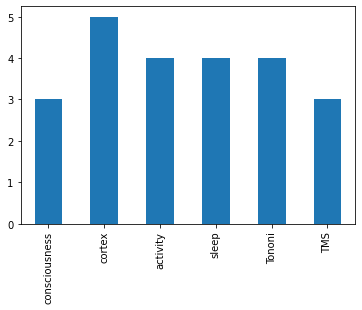

In [20]:
series = pd.Series(data=noun_counts)
series[series >= 3].plot.bar()

So it's not the top-5 words, but we can see that these results look more promising than the previous results. Still though, if we look at the dictionary of the nouns and their counts, there is a bit of a flaw.

In our ```noun_counts``` dictionary, the word ```neuroscientists``` has a frequency of 2, and the word ```neuroscientist``` has a frequency of 1. If we're trying to figure out what this article is about, we probably want to group these two words together somehow. Ie, we want to *normalize* these words.

### Normalization
Alright so, back to the ```neuroscientists``` and ```neuroscientist``` problem. We want to group these two tokens together (or count them as the same "token"). This process is called *normalization*, where we extract the stem of a word.

We can do this by **stemming** or by **lemmatization**. Either method will work, but because our sample size is relatively small, I'm going to opt for lemmatization. Stemming sometimes gives us stems that aren't actually words, and thus less accurate results while lemmatization, although more expensive, always gives us an actual word.

Let's go back to the first article and get a new dictionary of the word counts, except this time, we will lemmatize the words according to their POS-tag.

In [34]:
from nltk import WordNetLemmatizer
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tagged_tokens):
    lemmatized_tokens = []
    for token in tagged_tokens:
        if token[1].startswith("NN"):
            next = lemmatizer.lemmatize(token[0], pos='n')
        elif token[1].startswith("VB"):
            next = lemmatizer.lemmatize(token[0], pos='v')
        elif token[1].startswith("JJ"):
            next = lemmatizer.lemmatize(token[0], pos='a')
        else:
            next = token[0]
        
        lemmatized_tokens.append(next)
    return lemmatized_tokens

def get_lemmatized_noun_counts(tagged_tokens):
    nouns = list(filter(lambda t: t[1].startswith("NN"), tagged_tokens))
    counts = defaultdict(int)

    for noun in nouns:
        counts[lemmatizer.lemmatize(noun[0])] += 1
    return counts

lemmatized_nouns = get_lemmatized_noun_counts(tagged_tokens[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


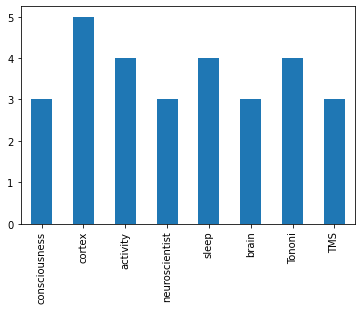

In [22]:
series = pd.Series(data=lemmatized_nouns)
series[series >= 3].plot.bar()

These results are definitly an improvement. Let's see what the results look like for the rest of the articles.

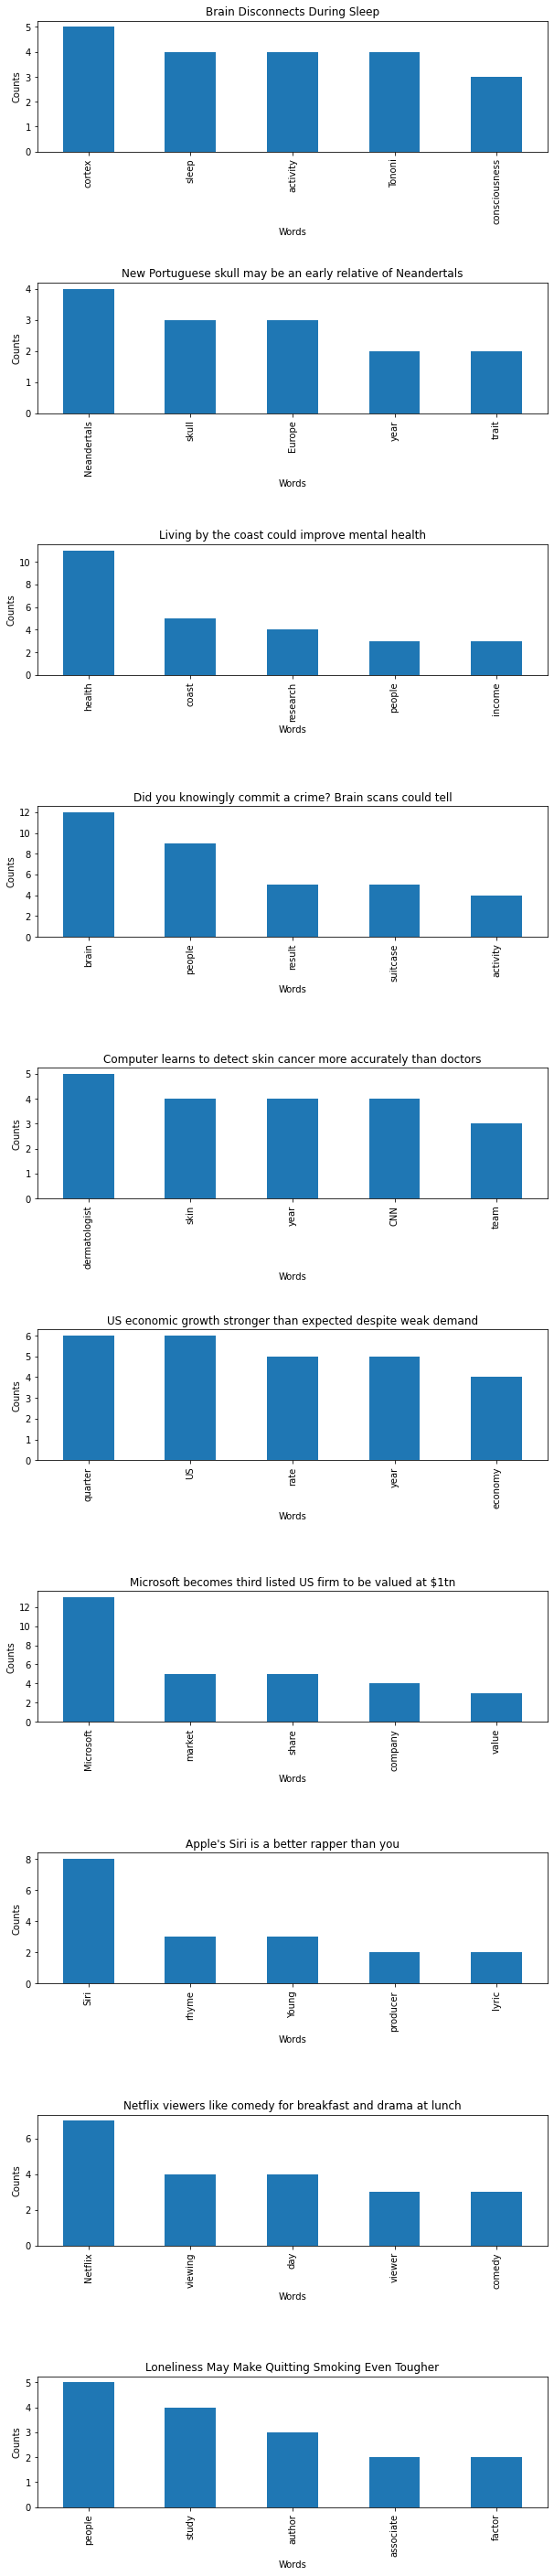

In [23]:
counts = [get_lemmatized_noun_counts(tokens) for tokens in tagged_tokens]

fig, axs = plt.subplots(10, gridspec_kw={'hspace': 1}, figsize=(10, 50))

for i, title in zip(range(0, 10), titles):
    series = pd.Series(data=counts[i])
    series.sort_values(ascending=False).head().plot(ax=axs[i], kind='bar', ylabel='Counts', xlabel='Words').set_title(title)

On a quick scan, the normalized results are much better than the non-normalized results. However, there are a few outliers. Consider the last article about smoking and loneliness. The article is about *smoking*, a verb, and *loneliness* and adjective. For this project, I have restricted the words we're looking at to just the nouns, which is a problem for this corpa. We could have an article about *doing something* where the subject of the article is about an action ie. a verb. 

In the future, if I were to redo this project. I wouldn't want to restrict this to just looking at the nouns. I hypothesize that for some articles, including the verbs and adjectives would improve my results.

### TF-IDF Scores
For the final part of this project, I'm going to be using scikit-learns ```sklearn``` library to calculate the TF-IDF scores for each of the words across the 10 articles. 

To start, I'm going to import sklearn and the ```TfidfVectorizer``` and create a new variable ```tfidf_matrix``` that will contain all of the word scores.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# First get the lemmatized tokens
lemmatized_tokens = [lemmatize_tokens(tokens) for tokens in tagged_tokens]

# Create and instance of the TfidfVectorizer
tfidf_vectorization = TfidfVectorizer()

# Create the tfidf matrix
tfidf_matrix = tfidf_vectorization.fit_transform([" ".join(tokens) for tokens in lemmatized_tokens]).toarray()

To see a full list of all of the words we're scoring we can call ```tfidf_vectorization.get_feature_names()```. Let's just get the first and last 5 items.

In [35]:
feature_names = tfidf_vectorization.get_feature_names()
print(feature_names[:5])
print(feature_names[-5:])

['000', '03', '10', '100', '118']
['york', 'young', 'yourself', 'zealand', 'zone']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The scores for each token, for each piece of text are buried inside of ```tfidf_matrix```. To extract them I'm going to zip together the feature names and a row from ```tfidf_matrix``` into a dictionary. This will give us a better idea of the actual scores for each of the tokens. 

In [36]:
article1 = dict(zip(tfidf_vectorization.get_feature_names(), tfidf_matrix[0]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This still looks like a big mess, but we can see (a little more clearly) which word corresponds to which value for a given text in the matrix this way. Now I'm going to create a list of dictionaries like this for each of the our texts. I'm going to call it the ```pretty_tfidf_matrix```

In [27]:
pretty_tfidf_matrix = [dict(zip(tfidf_vectorization.get_feature_names(), tfidf_matrix[i])) for i in range(0, 10)]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now, we want to get the highest scoring values from each of these dictionaries. For this, we'll just sort our dictionary using Python's built in ```sorted``` method. We'll start by just sorting the tokens for the first text. I'm going to take a slice of the top-10 tokens.

In [28]:
sorted(pretty_tfidf_matrix[0], key=lambda x: pretty_tfidf_matrix[0][x] ,reverse=True)[:10]

['cortex',
 'sleep',
 'consciousness',
 'tononi',
 'communication',
 'electrical',
 'non',
 'rem',
 'tms',
 'activity']

These results look pretty damn good, however, the results appear to be no different than getting the token counts of the nouns. Let's see what the results look like for the other texts. For this, we're going to reduce the scores to just the top-5 scores, just to make things easier to look at.



In [29]:
top_5_scores = [sorted(pretty_tfidf_matrix[i], key=lambda x: pretty_tfidf_matrix[i][x] ,reverse=True)[:5] for i in range(0, 10)]
top_5_scores

[['cortex', 'sleep', 'consciousness', 'tononi', 'communication'],
 ['neandertals', 'skull', 'europe', 'fossil', 'eventually'],
 ['health', 'live', 'coast', 'mental', 'access'],
 ['brain', 'know', 'people', 'suitcase', 'study'],
 ['dermatologist', 'melanoma', 'skin', 'cnn', 'benign'],
 ['growth', 'rate', 'us', 'quarter', 'economy'],
 ['microsoft', 'cloud', 'market', 'share', 'company'],
 ['siri', 'like', 'rhyme', 'know', 'young'],
 ['netflix', 'day', 'viewing', 'watch', 'breakfast'],
 ['smoke', 'loneliness', 'quit', 'people', 'find']]